In [114]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 17.0
plt.rc('text', usetex=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
df = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
df = df[df['TeamID'] == 'Huskies'] # We only study Huskies now
df

,MatchID,TeamID,OriginPlayerID,DestinationPlayerID,MatchPeriod,EventTime,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y
0,1,Huskies,Huskies_D1,Huskies_F1,1H,46.323501,Head pass,34,97,59.0,95.0
1,1,Huskies,Huskies_M1,Huskies_F2,1H,51.022546,Simple pass,53,89,69.0,91.0
4,1,Huskies,Huskies_M2,Huskies_M3,1H,98.265191,Simple pass,42,55,36.0,54.0
8,1,Huskies,Huskies_D1,Huskies_F1,1H,130.656530,Head pass,34,91,52.0,97.0
11,1,Huskies,Huskies_D1,Huskies_G1,1H,161.221470,Simple pass,14,65,11.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...
23405,38,Huskies,Huskies_D4,Huskies_F6,2H,2676.466810,Simple pass,66,15,62.0,23.0
23406,38,Huskies,Huskies_F6,Huskies_M2,2H,2679.856529,Simple pass,62,23,66.0,39.0
23407,38,Huskies,Huskies_M2,Huskies_M1,2H,2682.271344,Simple pass,66,39,63.0,63.0
23408,38,Huskies,Huskies_M1,Huskies_F4,2H,2683.754085,Simple pass,63,63,73.0,55.0


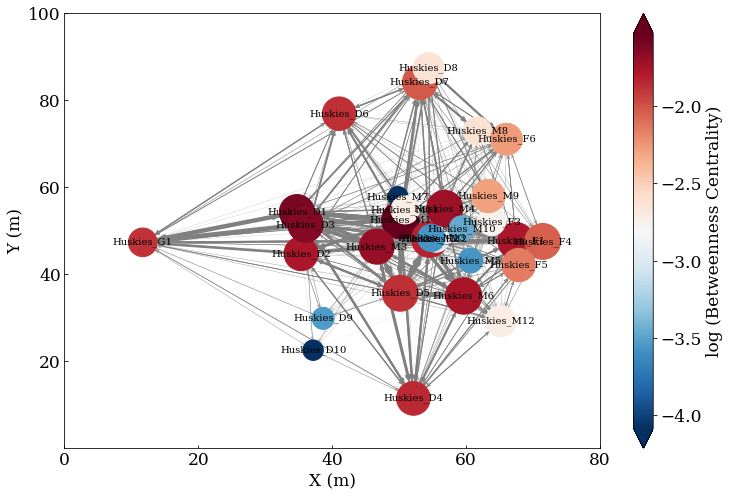

In [92]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = plot_network(df, team='Huskies', matchid='all', ax=ax, font_family='serif', font_size=10)

### 清理之后的布阵图
D1, D2, D3

D7, D8

D9, D10

F1, F4, F5

F2, M13, M2

M8, F6

Not M7, M11, M1

In [108]:
df_reduce = df.copy()

In [109]:
for ind, row in df_reduce.iterrows():
    for prefix in ['OriginPlayerID', 'DestinationPlayerID']:
        if row[prefix].strip('Huskies_') in ['D1', 'D2', 'D3']:
            df_reduce.loc[ind, prefix] = 'Huskies_D1'
        if row[prefix].strip('Huskies_') in ['D7', 'D8']:
            df_reduce.loc[ind, prefix] = 'Huskies_D7'
        if row[prefix].strip('Huskies_') in ['D9', 'D10']:
            df_reduce.loc[ind, prefix] = 'Huskies_D9'
        if row[prefix].strip('Huskies_') in ['F1', 'F4', 'F5']:
            df_reduce.loc[ind, prefix] = 'Huskies_F1'
        if row[prefix].strip('Huskies_') in ['F2', 'M13', 'M2']:
            df_reduce.loc[ind, prefix] = 'Huskies_M2'
        if row[prefix].strip('Huskies_') in ['M8', 'F6']:
            df_reduce.loc[ind, prefix] = 'Huskies_F6'
        #if row[prefix].strip('Huskies_') in ['M7', 'M11', 'M1']:
        #    df_reduce.loc[ind, prefix] = 'Huskies_M1'

In [110]:
from network import build_network, plot_network

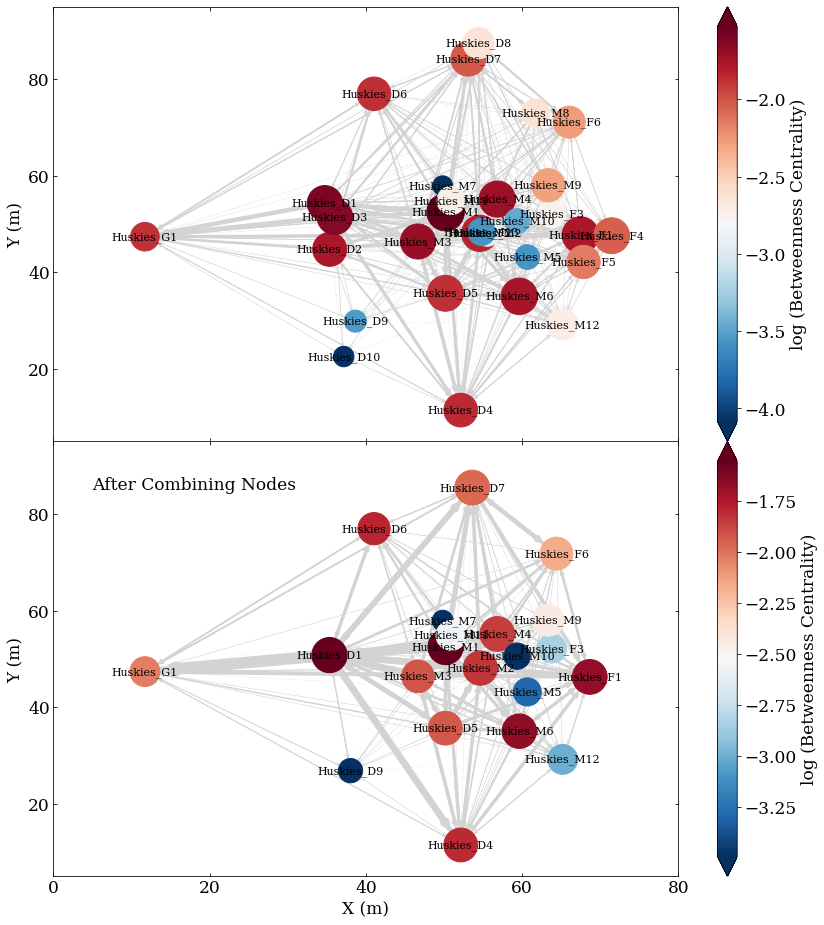

In [125]:
# Plot network for each match
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

ax1 = plot_network(df, team='Huskies', matchid='all', 
                   ax=ax1, font_family='serif', font_size=11)
ax1.tick_params(direction='in', left=True, right=True, 
                bottom=True, top=True, labelleft=True, labelbottom=False)
ax1.set_xlim(0, 80)
ax1.set_ylim(5, 95)

ax2 = plot_network(df_reduce, team='Huskies', matchid='all', 
                   ax=ax2, font_family='serif', font_size=11)
ax2.tick_params(direction='in', left=True, right=True, 
                bottom=True, top=True, labelleft=True, labelbottom=True)
ax2.set_xlim(0, 80)
ax2.set_ylim(5, 95)

ax2.text(5, 85, 'After Combining Nodes')
plt.subplots_adjust(hspace=0)
plt.savefig('./Draft/Huskies-network.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/Huskies-network.png', dpi=200, bbox_inches='tight')

## Calculate Motifs

### 3-nodes motifs

In [57]:
from network import motifs_2, motifs_3, mcounter
motif_count, motif_weight = mcounter(G, motifs_3, weight_dict)
motif_count, motif_weight

({'S1': 3,
  'S2': 8,
  'S3': 31,
  'S4': 3,
  'S5': 1,
  'S6': 6,
  'S7': 63,
  'S8': 215,
  'S9': 1,
  'S10': 14,
  'S11': 10,
  'S12': 202,
  'S13': 651},
 {'S1': 4.418216303079592,
  'S2': 7.390295268821181,
  'S3': 223.43579040766963,
  'S4': 1.4826603350742262,
  'S5': 2.058451886887468,
  'S6': 53.13320735020808,
  'S7': 474.6628630994571,
  'S8': 2909.378512039331,
  'S9': 13.78146890221802,
  'S10': 106.63402569985128,
  'S11': 154.15539635212434,
  'S12': 4422.711608836926,
  'S13': 34419.123029320035})

In [58]:
motif_df = pd.DataFrame([motif_weight, motif_count], index=['weight', 'count']).T.sort_values('weight')[::-1]
prominent_motif = motif_df[motif_df['weight'].values > np.median(motif_df['weight'].values)]

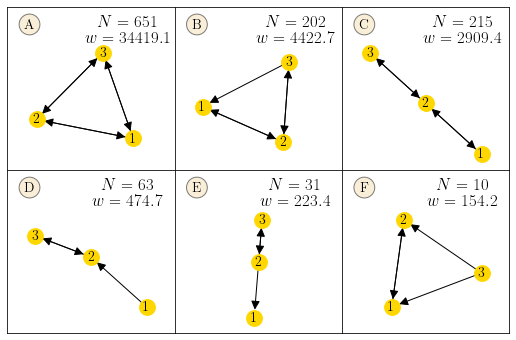

In [60]:
plt.rc('text', usetex=True)
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
tag_set = ['A', 'B', 'C', 'D', 'E', 'F']

for ind, row in enumerate(prominent_motif.iterrows()):
    name = row[0]
    weight = row[1]['weight']
    count = row[1]['count']
    ax = axes[ind // 3, ind % 3]
    ax.axis('on')
    nx.draw_networkx(motifs_3[name], pos=nx.spring_layout(motifs_3[name], center=np.array([0, -0.40])), 
                     ax=ax, 
                     node_size=250, 
                     node_color='gold',
                     font_size=14,
                     arrowsize=18)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.7, 1.5)
    
    ax.text(0.65, 0.88, r'$w={:.1f}$'.format(weight), 
            horizontalalignment='center', 
            verticalalignment='center')
    ax.text(0.65, 1.2, r'$N={:d}$'.format(int(count)), 
            horizontalalignment='center', 
            verticalalignment='center')
    
    ax.text(-1.1, 1.15, tag_set[ind], 
            fontsize=14,
            horizontalalignment='center', 
            verticalalignment='center',
            bbox=dict(boxstyle='circle', facecolor='wheat', alpha=0.5))
    
plt.subplots_adjust(wspace=0, hspace=0)

#plt.savefig('./Draft/motif3-Huskies-total.pdf', dpi=200, bbox_inches='tight')
#plt.savefig('./Draft/motif3-Huskies-total.png', dpi=200, bbox_inches='tight')

### 2-nodes motifs

In [62]:
motif_count, motif_weight = mcounter(G, motifs_2, weight_dict)
motif_count, motif_weight

({'S1': 44, 'S2': 314}, {'S1': 43.97869670934888, 'S2': 4496.257103693947})

In [63]:
motif_df = pd.DataFrame([motif_weight, motif_count], index=['weight', 'count']).T.sort_values('weight')[::-1]
prominent_motif = motif_df

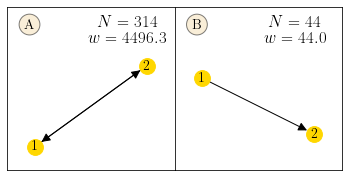

In [64]:
plt.rc('text', usetex=True)
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
tag_set = ['A', 'B', 'C', 'D', 'E', 'F']

for ind, row in enumerate(prominent_motif.iterrows()):
    name = row[0]
    weight = row[1]['weight']
    count = row[1]['count']
    ax = axes[ind]
    ax.axis('on')
    nx.draw_networkx(motifs_2[name], pos=nx.spring_layout(motifs_2[name], center=np.array([0, -0.45])), 
                     ax=ax, 
                     node_size=250, 
                     node_color='gold',
                     font_size=14,
                     arrowsize=18)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.7, 1.5)
    
    ax.text(0.65, 0.88, r'$w={:.1f}$'.format(weight), 
            horizontalalignment='center', 
            verticalalignment='center')
    ax.text(0.65, 1.2, r'$N={:d}$'.format(int(count)), 
            horizontalalignment='center', 
            verticalalignment='center')
    
    ax.text(-1.1, 1.15, tag_set[ind], 
            fontsize=14,
            horizontalalignment='center', 
            verticalalignment='center',
            bbox=dict(boxstyle='circle', facecolor='wheat', alpha=0.5))
    
plt.subplots_adjust(wspace=0, hspace=0)

#plt.savefig('./Draft/motif2-Huskies-total.pdf', dpi=200, bbox_inches='tight')
#plt.savefig('./Draft/motif2-Huskies-total.png', dpi=200, bbox_inches='tight')